Shape of X_train: (1198, 60, 1)
Shape of y_train: (1198,)

Training the RNN...


C:\Users\bhoom\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 0.0953
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0071
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0062
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0050
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0049
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0044
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0045
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0052
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0043
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0042
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0041
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0049
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0037
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0036
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - 

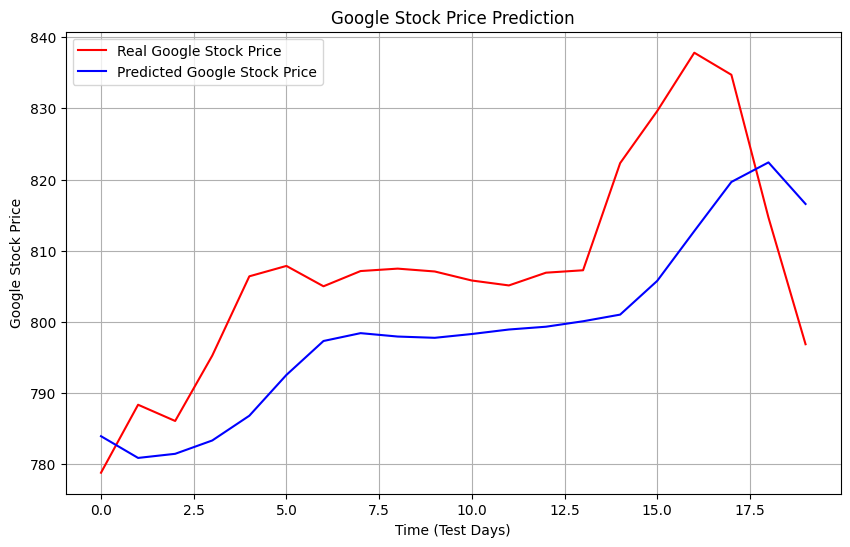

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# --- Part 1 - Data Preprocessing ---

# Importing the training set
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
# Explicitly select the 'Open' column. If your relevant column is different, change 'Open'.
training_set = dataset_train[['Open']].values

# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
timesteps = 60 # Define the number of timesteps/lookback period

# Use len() for dynamic range
for i in range(timesteps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping for LSTM input (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# --- Part 2 - Building and Training the RNN ---

# Initializing the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularization
# input_shape is only needed for the first layer
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM Layer and some Dropout regularization
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Adding a Third LSTM Layer and some Dropout regularization
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM Layer and some Dropout regularization
# CRITICAL CORRECTION: return_sequences=False for the last LSTM before a Dense layer
regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units=1))

# Compile the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Fit the RNN to the training set
print("\nTraining the RNN...")
regressor.fit(X_train, y_train, epochs=100, batch_size=32)
print("RNN training complete.")

# --- Part 3 - Making Predictions and Visualizing the Results ---

# Getting the real stock price of 2017
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
# Explicitly select the 'Open' column for consistency
real_stock_price = dataset_test[['Open']].values

# Getting the predicted stock price of 2017
# Concatenate 'Open' column from both datasets
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)

# Prepare inputs for the test set. Need previous 'timesteps' values from the training data.
# The index starts from (length of total dataset - length of test dataset - timesteps)
# This slice includes the last 'timesteps' values from training and all test values.
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values
inputs = inputs.reshape(-1, 1) # Reshape to a column vector for the scaler
inputs = sc.transform(inputs) # Apply the same scaler used on training data

X_test = []
# Create test sequences. The loop goes from 'timesteps' to the end of the 'inputs' array.
for i in range(timesteps, len(inputs)): # Use len() for dynamic range
    X_test.append(inputs[i-timesteps:i, 0])

X_test = np.array(X_test)

# Reshaping X_test for LSTM input
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Shape of X_test:", X_test.shape)

# Make predictions
predicted_stock_price = regressor.predict(X_test)
# Inverse transform the predictions to get actual stock prices
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print("Shape of real_stock_price:", real_stock_price.shape)
print("Shape of predicted_stock_price:", predicted_stock_price.shape)

# Visualising the results
plt.figure(figsize=(10, 6)) # Optional: set figure size for better readability
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time (Test Days)')
plt.ylabel('Google Stock Price')
plt.legend()
plt.grid(True) # Optional: add a grid for better visualization
plt.show()
